<a href="https://colab.research.google.com/github/Hamza1122/DL-Assignment/blob/master/ECMM422_CA1_Classifiers_2020_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 1: Classifiers</H2>



| <font style="font-size:larger;">Date set     | <font style="font-size:larger;">Hand-in date |
|:------------------|:-----------------------------------|
|<font style="font-size:larger;"> 24th January 2019 |<font style="font-size:larger;">**  12 noon, Wednesday 5th February 2020** |

</font>

Candidate number:  <font color="red">*Please put your candidate number here*</font>

Marking is anonymous, so please don't write your name or reveal your identity!


The module assessment is comprised of your IPython notebooks. There will be four marked assignments, of which this is the first. All assignments will be equally weighted and therefore worth 25% of your module mark. 


Your IPython notebook should show what you did, what was the
result, and what you can conclude from the exercise. For some reports you will need to comment on a paper you have read.   Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>



<div class="alert alert-info">
 Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
 </div>

In [0]:
import numpy as np
import matplotlib.pyplot as plt 

## 1. Classification

In the first part of this workshop, we will work on a simple classification problem with synthetic data. The dataset has one binary target $t\in \{0,1\}$ and two features $\mathbf{x} = [x_1,x_2]$. This will allow to visualise the data and model decision boundary on 2D plots.

First, you should download and load the data in from two files on the VLE, the files should be placed in the same folder as the jupyter notebook. The files contain the $\mathbf{x}$ and $t$ values for 500 samples.

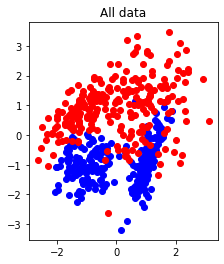

In [33]:
# we first load each file in a separate array
Xall = np.load('ecmm422_ca1_part1_X.npy')
tall = np.load('ecmm422_ca1_part1_t.npy')

# then we plot all data using matplotlib - note the indexing to select only samples from one class or the other
plt.plot(Xall[tall==0, 0], Xall[tall==0, 1], 'bo')
plt.plot(Xall[tall==1, 0], Xall[tall==1, 1], 'ro')
plt.axis('scaled')
plt.title('All data')
plt.show()

It is clear that it cannot be completely separated by a straight line, so these data are said not to be "linearly separable".

The first step in any machine learning work will be to separate and put aside a test set for final evaluation. Often this set will be sampled randomly from the available data, but for this workshop we will use a specific subset of half the data so that performance is comparable. 

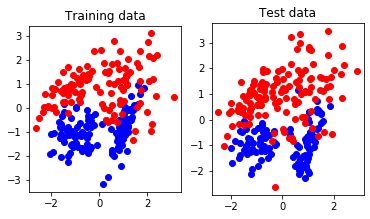

In [34]:
I = range(len(tall))    # you could change this for np.random.permutation(len(tall)) to get a random selection
                        # do not do this for this workshop as I want to be able to compare final performance. 

Itrain = I[:len(tall)//2]   # First half of indices for training
Itest = I[len(tall)//2:]    # Second half for test

Xtr = Xall[Itrain,:] # we define variables for the training set...
ttr = tall[Itrain]   

Xte = Xall[Itest,:]  # ... and for the test set
tte = tall[Itest]   

# then we plot both sets
plt.subplot(121)
plt.plot(Xtr[ttr==0, 0], Xtr[ttr==0, 1], 'bo')
plt.plot(Xtr[ttr==1, 0], Xtr[ttr==1, 1], 'ro')
plt.axis('scaled')
plt.title('Training data')

plt.subplot(122)
plt.plot(Xte[tte==0, 0], Xte[tte==0, 1], 'bo')
plt.plot(Xte[tte==1, 0], Xte[tte==1, 1], 'ro')
plt.axis('scaled')
plt.title('Test data')

# note that we would usually also label axes, but in this case the features 
# are unnamed so this would not add much information. 

plt.show()


Good. We can see in those plots that the two distributions are comparable, so we did not create a pathological split (eg, one that would contain only one class!) by accident. 

<b>NB:</b> We must <b>not</b> use the test data as part of the training process.

We will use three different algorithms in this workshop: k-NN, Neural Networks and decision trees. 

### 1.1 Classification with k-nearest neighbours
As a first step, we will try to model the dataset distribution using k-Nearest Neighbours. 
We will use the k-nearest neighbour classifier from scikit learn, which is  quite an extensive implementation of various machine learning algorithms.

In [0]:
from sklearn import neighbors

To start off, we use **all** the training data.

In [36]:
k = 5   # Choose the number of nearest neighbours

knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtr, ttr)

# we can get the performance on the training set
Str = knn.score(Xtr, ttr)

# we can also calculate the performance on the test set: 
Ste = knn.score(Xte, tte)

print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))


Performance with k=5,
	- on training set 0.952000 
	- on test set 0.916000


In the following cell, we will set up a grid of points to be classified over the whole domain and then classify them with the k-nn classifier, plotting the result in the corresponding place on the grid.  This gives a nice visualisation of the classfier's performance.


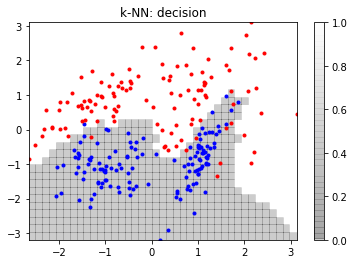

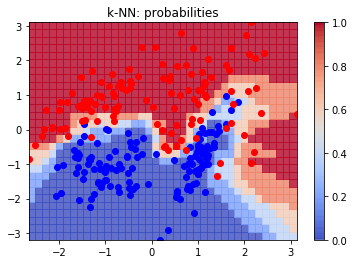

In [37]:
# we use this to calculate classification accuracy, you can as easily calculate it by hand though. 
from sklearn import metrics

def plot_decision_regions(X, t, model, label='model', show_decision=True, show_probabilities=True):
    '''
    For convenience, we will use this function to draw the decision boundaries and probabilities of the learnt 
    models. 
    Xtr: the features 
    ttr: the labels
    model: the trained model to display
    label: the name of the model (for figure captions)
    show_decision: draw decision boundary plot (default: true)
    show_probabilities: draw class probabilities (default: true)
    '''
    N, M = 40, 30   # Make these larger to get a smoother picture

    X1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), N)
    X2 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), M)
    pred = np.zeros((M,N))
    prob = np.zeros((M,N,2))

    # Writing this double loop is not very efficient, but it is clear.
    for nx2, x2 in enumerate(X2):
        for nx1, x1 in enumerate(X1):
            pred[nx2, nx1] = model.predict([[x1, x2]])          # Predict expects a matrix of features
            if show_probabilities:
                prob[nx2, nx1, :] = model.predict_proba([[x1, x2]]) # Probabilities of belonging to one class
            

    if show_decision:
        plt.figure() 
        plt.pcolor(X1, X2, pred, cmap=plt.cm.gray, alpha=0.2)
        plt.colorbar()
        plt.plot(X[t==0,0], X[t==0,1], 'b.')
        plt.plot(X[t==1,0], X[t==1,1], 'r.')
        plt.axis('tight')
        plt.title('{}: decision'.format(label))

    if show_probabilities:
        # Plot the probabilites of belonging to the 1 class.
        plt.figure()
        plt.pcolor(X1, X2, prob[:,:,1], cmap=plt.cm.coolwarm, alpha=0.8)
        plt.colorbar()
        plt.plot(X[t==0,0], X[t==0,1], 'bo')
        plt.plot(X[t==1,0], X[t==1,1], 'ro')
        plt.axis('tight')
        plt.title('{}: probabilities'.format(label))
        
plot_decision_regions(Xtr, ttr, model=knn, label='k-NN')

Above we used all the training data and guessed the value of $k$. Much better is to estimate the optimum value of $k$, but dividing the training data into a training and a <b>validation</b> set; the generalisation error is then estimated on the validation set and the $k$ giving the minimum error is used for making predictions about unknown data.

Better than just dividing the training data into two is to use $k$ fold <b>cross validation</b> (don't confuse the $k$ in $k$ cross validation with the $k$ in $k$ nearest neighbours!)

The following cell shows how the sklearn routines may be used to produce training and validation sets automatically. More information at <http://scikit-learn.org/stable/modules/cross_validation.html>.  Don't worry about the deprecation warnings!

In [38]:
from sklearn.model_selection import KFold

# Make our 'training data' of 10 examples, each of two columns.
# These have just got integers in so that you can easily see which 
# examples have been selected.
X = np.vstack((np.arange(10), np.arange(10))).T + 10
t = np.arange(10)+100   # Targets

print("Features")
print(X)
print("Targets")
print(t)
print()
print()

kf = KFold(n_splits=5, shuffle=True)    # 5 fold CV here.
unq=[]
fold = 0
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
for train, validation in kf.split(X):

    #print('-------- Fold', fold)
    #print('Train')
    #print(X[train])
    #print(t[train])
    X_train, X_val = X[train], X[validation]
    y_train, y_val = t[train], t[validation]
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    print("Error on validation set",1-metrics.accuracy_score(y_val, y_pred))
    
    # we can get the performance on the training set
    
    
    #print('Test')
    #print(X[validation])
    #print(t[validation])
    fold += 1
    # Notice that each training set consists of 8 of the 10 examples 
    # and the validation set is the remaining 2.
    # You should train the model with X[train] and t[train]
    # and estimate the generalisation error on X[validation] and 
    # t[validation].  Don't forget to average the validation error 
    # over all the folds - you can also estimate the standard deviation 
    # to get error bars on the validation error!

Features
[[10 10]
 [11 11]
 [12 12]
 [13 13]
 [14 14]
 [15 15]
 [16 16]
 [17 17]
 [18 18]
 [19 19]]
Targets
[100 101 102 103 104 105 106 107 108 109]


Error on validation set 1.0
Error on validation set 1.0
Error on validation set 1.0
Error on validation set 1.0
Error on validation set 1.0


Make a plot of the training and validation errors as $k$ varies from 1 to, say, 50.  Here, just use the number of misclassified samples as the error, but you could also use the cross entropy (how do they differ?). 
<div style="text-align: right"><b>[10 marks]</b></div>

*  What is the best value of $k$?  
   
*  What is the error on the **test** set with the best $k$?

*  Make a plot of the decision regions (as above) with the best $k$
*  What can you say about the performance of the classifier when $k$ is too large or too small?
*  How do you think the optimum $k$ will vary if the amount of training data available is larger or smaller than 250 points?  Can you test your hypothesis?
<div style="text-align: right"><b>[10 marks]</b></div>

### 1.2 Multi-layer perceptrons (MLP)

Multi-layer perceptrons are the sorts of neural networks that have been described in lectures.  In this section we'll use an MLP with weight decay regularisation to classify the same data again. 

The next cell sets up an MLP with 5 hidden units and the given regularisation constant ($\alpha$), trains it a few times from random starting places to find the best minimum (because $E(\mathbf{w})$ may have local minima) and uses it to classify points on a grid as above.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Performance with k=5,
	- on training set 0.964000 
	- on test set 0.892000


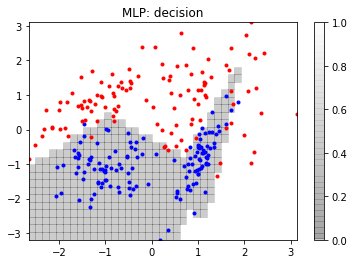

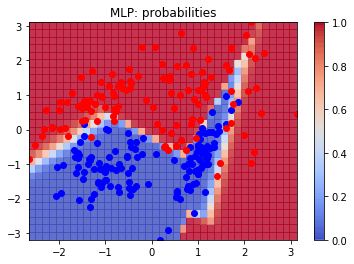

In [39]:
# load the Multi-Layer Perceptron class from Scikit-Learn
from sklearn.neural_network import MLPClassifier

# because initialisation is random, we train 10 times and take the best model (according to *training* error)
Ebest = np.Inf
for n in range(10):
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,))
    mlp.fit(Xtr, ttr)
    if mlp.loss_ < Ebest:
        mlpbest = mlp
        Ebest = mlp.loss_
mlp = mlpbest


plot_decision_regions(X=Xtr, t=ttr, model=mlp, label='MLP', show_decision=True, show_probabilities=True)

Ste = mlp.score(Xte, tte)
Str = mlp.score(Xtr, ttr)
print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))


Experiment with different values of the regularisation constant, plotting the decision boundaries to visualise how the regularisation forces a smooth or more wiggly boundary.  Remember to vary $\alpha$ on a logarithmic scale and it could range between $10^{-16}$ (effectively 0) and $1$. 

<div style="text-align: right"><b>[5 marks]</b></div>

Performance with k=5,
	- on training set 0.964000 
	- on test set 0.908000


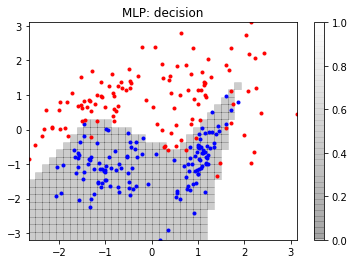

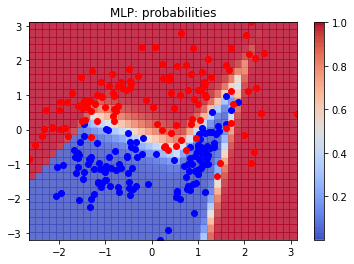

In [40]:
#generating different values of regularisation constant
alphas = np.logspace(-16,1,10)

array=np.array(alphas)
# because initialisation is random, we train 10 times and take the best model (according to *training* error)
Ebest = np.Inf
for n in array:
                                        #taking alpha values from an array  
    mlp = MLPClassifier(solver='lbfgs', alpha=n, hidden_layer_sizes=(5,))
    mlp.fit(Xtr, ttr)
    if mlp.loss_ < Ebest:
        mlpbest = mlp
        Ebest = mlp.loss_
mlp = mlpbest
plot_decision_regions(X=Xtr, t=ttr, model=mlp, label='MLP', show_decision=True, show_probabilities=True)
Ste = mlp.score(Xte, tte)
Str = mlp.score(Xtr, ttr)
print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))



Use cross-validation to choose the best value of the regularisation constant for these data.   Plot the training and validation data errors versus $\alpha$.  How well does the validation error correspond to the actual test error?

<div style="text-align: right"><b>[5 marks]</b></div>

In [45]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

kf = KFold(n_splits=10)

alphas = np.logspace(-5,1,10)
array=np.array(alphas)
Ebest = np.Inf
for x in array:

  clf = MLPClassifier(solver='lbfgs', alpha=x, hidden_layer_sizes=(5, 2), random_state=1)


val=[]
train=[]
for train_indices, val_indices in kf.split(Xtr):
    clf.fit(Xtr[train_indices], ttr[train_indices])
    print("Accuracy on validation dataset ",clf.score(Xtr[val_indices],ttr[val_indices]))
    print("Accuracy on training dataset ",clf.score(Xtr[train_indices],ttr[train_indices]))
    
    val.append(clf.score(Xtr[val_indices],ttr[val_indices]))
    train.append(clf.score(Xtr[train_indices],ttr[train_indices]))



Accuracy on validation dataset  0.88
Accuracy on training dataset  0.8933333333333333
Accuracy on validation dataset  0.88
Accuracy on training dataset  0.8844444444444445
Accuracy on validation dataset  0.84
Accuracy on training dataset  0.8933333333333333
Accuracy on validation dataset  0.88
Accuracy on training dataset  0.8888888888888888
Accuracy on validation dataset  0.96
Accuracy on training dataset  0.8844444444444445
Accuracy on validation dataset  0.8
Accuracy on training dataset  0.9111111111111111
Accuracy on validation dataset  0.96
Accuracy on training dataset  0.8755555555555555
Accuracy on validation dataset  0.88
Accuracy on training dataset  0.8844444444444445
Accuracy on validation dataset  0.92
Accuracy on training dataset  0.88
Accuracy on validation dataset  0.88
Accuracy on training dataset  0.9022222222222223


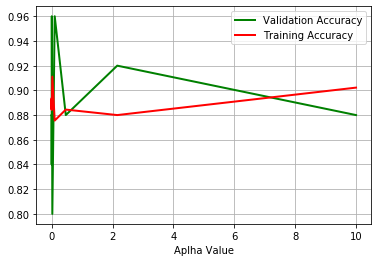

In [46]:
import matplotlib.pyplot as plt
import operator

fig, ax = plt.subplots()

ax.plot(alphas, val, label='Validation Accuracy', color='g', linewidth=2)
ax.plot(alphas, train, label='Training Accuracy', color='r', linewidth=2)

plt.legend(loc='best')
plt.grid()
plt.xlabel("Aplha Value")
plt.show()


Bonus question:  How should the best value of $\alpha$ vary as the number of training examples is increased? Why? Can you test it? 

<div style="text-align: right"><b>[5 marks]</b></div>

### 1.3. Support Vector Machines (SVM)

Support vector machines (SVMs) are popular and powerful classifiers.  We'll deal with them in detail later in the module.  In the following you will use SVMs with both a "linear kernel" and with a RBF kernel.  With a linear kernel the SVM can only separate the classes with a straight line or a (hyper)plane, but an RBF kernel is nonlinear and allows the SVM to generate curved decision boundaries.  


We'll use the support vector machines in scikit learn.  Here's an example of training a SVM using a linear kernel (i.e., no non-linearity).

Performance:
	- on training set 0.904000 
	- on test set 0.880000


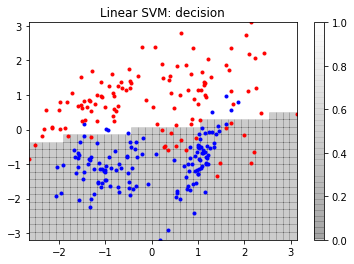

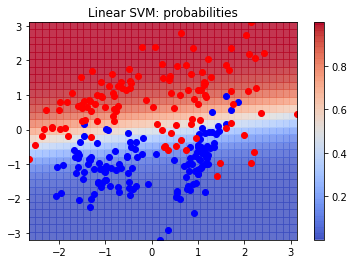

In [12]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)    # SVM with a linear kernel, 
                                                # note that enabling probabilities is slower
svm.fit(Xtr, ttr)                     # Train it on the training data

plot_decision_regions(X=Xtr, t=ttr, model=svm, label='Linear SVM', show_decision=True, show_probabilities=True)

Ste = svm.score(Xte, tte)
Str = svm.score(Xtr, ttr)
print('Performance:\n\t- on training set %f \n\t- on test set %f' % (Str, Ste))


Now use the SVM with <code>kernel='rbf'</code> to classify the data, but with a non-linear mapping so that the decision boundary can be non-linear. 

In this case the SVM has two additional parameters $C > 0$ and $\gamma$.  $C$ is a regularisation constant that controls how strongly points that lie on the wrong side of the decision boundary are penalised.  When $C$ is large, they are heavily penalised which results in the boundary being flexible, but when it is small they are lightly penalised so the boundary tends to be straighter.  You can set the value of $C$ (and $\gamma$) with

        svm = SVC(kernel='rbf', C=1, gamma=0.1) 

The default value of $C$ is 1 and the default value of $\gamma$ is 0.1.

Performance with C=1.000000, gamma=0.100000,
	- on training set 0.888000 
	- on test set 0.868000


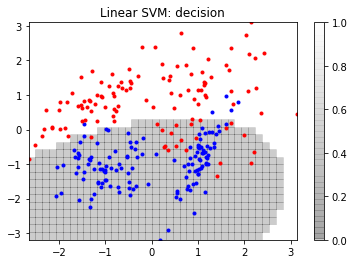

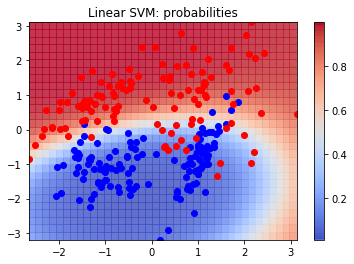

In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)            # SVM with a RBF kernel
svm.fit(Xtr, ttr)                     # Train it on the training data

plot_decision_regions(X=Xtr, t=ttr, model=svm, label='Linear SVM', show_decision=True, show_probabilities=True)

Ste = svm.score(Xte, tte)
Str = svm.score(Xtr, ttr)
print('Performance with C=%f, gamma=%f,\n\t- on training set %f \n\t- on test set %f' % (1, 0.1, Str, Ste))


The $\gamma$ parameter controls the width of the RBF kernel, that is how close training samples must be to interact with each other.  When $\gamma$ is large the training samples must be close to interact and the decision boundary tends to be nonlinear, whereas when $\gamma$ is small it tends to be smooth.

Use cross validation on the *training* data to choose the best value of $C$ and $\gamma$.  Try a few values of $C$ and $\gamma$ by hand first of all to find appropriate ranges and it will  be best to vary them on a logrithmic scale.  You may care to investigate and use the sklearn helper functions for searching a grid of values for the best cross validation value: see <http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#example-svm-plot-rbf-parameters-py> or write your own!

What is the resulting accuracy on the test data and the best decision boundary?

<div style="text-align: right"><b>[15 marks]</b></div>

In [14]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn import datasets
from sklearn import svm
kf = KFold(n_splits=10)
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
X_train, X_test, y_train, y_test = train_test_split(Xtr,ttr, test_size=0.3, random_state=0)
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid.fit(X_train, y_train) 


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.829, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.886, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.943, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.914, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.886, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.829, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.800, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.914, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.914, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.943, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.886, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.857, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.857, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [15]:
print(grid.best_params_) 
print(grid.best_estimator_) 


{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [16]:
from sklearn.metrics import accuracy_score
grid_predictions = grid.predict(X_test) 
print("Accuracy on test dataset",accuracy_score(y_test,grid_predictions))


Accuracy on test dataset 0.96


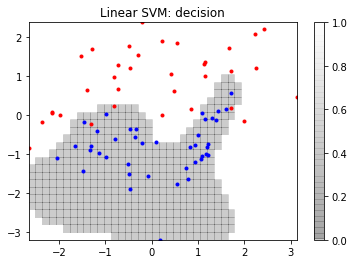

In [17]:
#best decision boundary
plot_decision_regions(X=X_test, t=y_test, model=grid, label='Linear SVM', show_decision=True, show_probabilities=False)



## Part 2: Digits dataset

In the second part, we will experiment with the same algorithm on a more complex dataset: examples images of hand-written digits. For this we will use a standard dataset provided by sklearn: <i>digits</i>

(1797, 64)
[0 1 2 3 4 5 6 7 8 9]


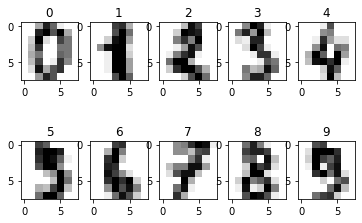

In [18]:
from sklearn import datasets

# (note: we overwrite the previous data here, make sure to reload it if you go back to part 1)
Xall, tall = datasets.load_digits(return_X_y=True)

print(Xall.shape)
print(np.unique(tall))

# print some examples of data from the dataset
for j in range(10):
    plt.subplot(2,5,j+1)
    plt.imshow(np.reshape(Xall[j,:], (8,8)), cmap=plt.cm.gray_r)
    plt.title("%d" % tall[j])
plt.show()

As you can see there are 1797 images arranged as 64-dimensional vectors, and defining 10 classes. In this case, the observed variables have many more dimensions, but we can use <i>multidimensional scaling</i> to visualise the distribution of the classes somehow (note that MDS on a large dataset can take a while).  

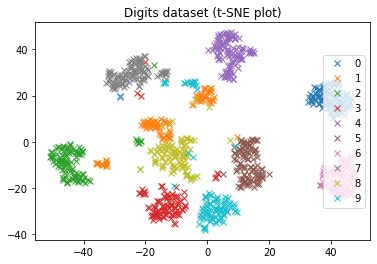

In [19]:
from sklearn.manifold import TSNE

# we select a subset of samples for speed 
Ntrain=1000
J = np.random.permutation(Xall.shape[0])[:Ntrain]
X = Xall[J,:]
t = tall[J]   # Features

# we then optimise the multidimensional scaling 
tsne = TSNE()
Xe = tsne.fit_transform(X)

# we then draw the classes on a 2D plot
for i in range(10):
    plt.plot(Xe[t==i,0], Xe[t==i,1], 'x', label='{}'.format(i))
plt.legend(loc='right')
plt.title('Digits dataset (t-SNE plot)')
plt.show()

This means that you have problem of <b>multiclass</b> classification. Some algorithms such as k-NN or MLPs can handle multiclass, whereas some other such as SVM need some additional work. 

In [20]:
#Example with k-NN:  

I = range(len(tall))    # you could change this for np.random.permutation(len(tall)) to get a random selection
                        # do not do this for this workshop as I want to be able to compare final performance. 

Itrain = I[:len(tall)//2]   # First half of indices for training
Itest = I[len(tall)//2:]    # Second half for test

Xtr = Xall[Itrain,:] # we define variables for the training set...
ttr = tall[Itrain]   

Xte = Xall[Itest,:]  # ... and for the test set
tte = tall[Itest]   

k = 5   # Choose the number of nearest neighbours

knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtr, ttr)

# we can get the performance on the training set
Str = knn.score(Xtr, ttr)

# we can also calculate the performance on the test set: 
Ste = knn.score(Xte, tte)

print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))


Performance with k=5,
	- on training set 0.988864 
	- on test set 0.955506


In a multiclass setting it is often worth calculating another error measure: the confusion matrix. This matrix tells you where your error comes from and whether two classes are specially confused.  

Confusion matrix, without normalization
[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  1  1]
 [ 1  0 80  5  0  0  0  0  0  0]
 [ 0  0  1 82  0  2  0  3  2  1]
 [ 0  0  0  0 87  0  0  1  0  4]
 [ 0  0  0  0  0 89  1  0  0  1]
 [ 0  0  0  0  0  0 91  0  0  0]
 [ 0  0  0  0  0  0  0 89  0  0]
 [ 0  5  1  1  0  0  0  1 79  1]
 [ 0  0  0  4  0  2  0  0  1 85]]


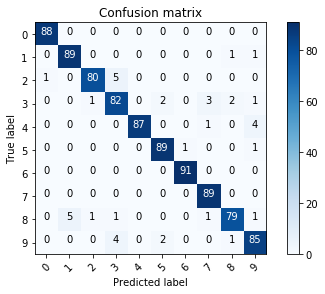

In [21]:
from sklearn import metrics
import itertools
from sklearn.metrics import confusion_matrix

# we predict the classes on the test data
pte = knn.predict(Xte)

# and we calculate the confusion matrix
cm = confusion_matrix(tte, pte)

np.set_printoptions(precision=2)


# code from: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
# now included in sklearn 0.22

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, np.unique(tte))

### 2.1 Digits with knn 
As a first shot, we will use the k-NN algorithm to try and model this dataset.
As we did before, use k-fold cross validation to find the best value of $k$. 
<div style="text-align: right"><b>[5 marks]</b></div>

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
Xtr = Xall[Itrain,:] # we define variables for the training set...
ttr = tall[Itrain]
kf = KFold(n_splits=10)
val=[]
train=[]
temp=[]
for train_indices, val_indices in kf.split(Xtr):
    X_train, X_val = Xtr[train_indices], Xtr[val_indices]
    y_train, y_val = ttr[train_indices], ttr[val_indices]
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    print("Error on validation set",1-metrics.accuracy_score(y_val, y_pred))

    print("Confusion Matrix",confusion_matrix(y_pred,y_val))



#both value of k and confusion matrix is included

Error on validation set 0.06666666666666665
Confusion Matrix [[11  0  0  0  0  0  0  0  0  0]
 [ 0  9  2  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  1]
 [ 0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  1]
 [ 0  0  1  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  1  0  0  0  6]]
Error on validation set 0.05555555555555558
Confusion Matrix [[ 9  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  4  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  1  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0 11]]
Error on validation set 0.011111111111111072
Confusion Matrix [[ 8  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  1  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0

### 2.2 Digits with MLP
As a second attempt 
As we did before, use k-fold cross validation to train an MLP on this data, optimising regularisation parameter $\alpha$ and the number of hidden units. 
<div style="text-align: right"><b>[10 marks]</b></div>

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

In [23]:
from sklearn import preprocessing
kf = KFold(n_splits=5)
#Xtr = preprocessing.scale(Xtr)



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)

Ebest = np.Inf
for x in array:

  clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)


val=[]
train=[]
for train_indices, val_indices in kf.split(Xtr):
    X_train, X_val = Xtr[train_indices], Xtr[val_indices]
    y_train, y_val = ttr[train_indices], ttr[val_indices]
    clf.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    print("Error on validation set",1-metrics.accuracy_score(y_val, y_pred))

    print("Confusion Matrix on MLP",confusion_matrix(y_pred,y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Error on validation set 0.5611111111111111
Confusion Matrix on MLP [[20  0  2  5 10  9  5 11 14 11]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  3 14  0  0  0  0  0  2  0]
 [ 0  9  0 12  1  1  3  0  1  8]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [ 0  6  0  0  0  0  0  0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Error on validation set 0.5833333333333333
Confusion Matrix on MLP [[18  3  4  3  9 12 15  6 11 11]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0 10 16  0  0  0  0  0  0  0]
 [ 0  1  0 19  0  0  3  1  5  2]
 [ 0  0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0 10  0  2]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]]
Error on validation set 0.6388888888888888
Confusion Matrix on MLP [[17  1  0 10 14 14 15  4 16 17]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  2 19  1  0  0  0  0  0  0]
 [ 0 12  0  6  0  1  2  0  3  0]
 [ 0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 14  0  2]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Error on validation set 0.6201117318435754
Confusion Matrix on MLP [[19  1  4  5 14 17 15  9  7 11]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  8 12  1  0  0  0  0  0  0]
 [ 0  4  1 12  0  0  1  0 10  0]
 [ 0 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### 2.3 Digits with SVM 
The last exercise in this workshop will be to use the SVM classifier for this data. In standard, SVMs only allow for binary classification. The standard approach to use them on multiclass problem is to decompose the problem in N 1 vs all classification problem: ie, in this case, this would mean learning one SVM for classifying digit 0 against all other (eg, [1,2,3,4,5,6,7,8,9]), a second classifier for classifying digit 1 against all others, etc. 
The final classification is given by the classifier that yields the strongest confidence. 

This is not too hard to implement, but luckily sklearn implements 1 vs all as standard in the SVC classes. 

Train linear an non linear SVMs, using k-fold cross validation to find the best value for $C$ and $\gamma$. 
<div style="text-align: right"><b>[10 marks]</b></div>

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

In [0]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [25]:
for train_indices, val_indices in kf.split(Xtr):
    X_train, X_val = Xtr[train_indices], Xtr[val_indices]
    y_train, y_val = ttr[train_indices], ttr[val_indices]
    

svm_model = GridSearchCV(SVC(), params_grid)
svm_model.fit(X_train,y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

encoder.fit(y_train)
y_train = encoder.transform(y_train)

encoder.fit(y_val)
y_val = encoder.transform(y_val)


# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_val)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.955506993006993 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [27]:
#Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print("\n")
print(classification_report(y_val,Y_pred_label))
print("Confusion Matrix on MLP",confusion_matrix(y_val,Y_pred_label))

svm_model.score



              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.86      1.00      0.93        19
           2       0.95      1.00      0.97        19
           3       1.00      1.00      1.00        18
           4       0.94      0.84      0.89        19
           5       1.00      1.00      1.00        18
           6       0.94      0.89      0.91        18
           7       0.90      1.00      0.95        19
           8       1.00      0.69      0.81        16
           9       0.94      1.00      0.97        17

    accuracy                           0.94       179
   macro avg       0.95      0.94      0.94       179
weighted avg       0.95      0.94      0.94       179

Confusion Matrix on MLP [[16  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  2  0  1]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 1  0  0  0  1 

<bound method BaseSearchCV.score of GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

Compare performance of all 3 algorithms for this problem. Discuss the differences in the remaining errors and what would be your suggestion going forward with this dataset. 
<div style="text-align: right"><b>[10 marks]</b></div>